# Pré-processamento de dados EEG

Até o momento vimos como carregar e preparar os dados de um *dataset*. Agora vamos plotar os dados de alguns eletrodos do arquivo preparado para visualizá-los no domínio do tempo e da frequência. Após visualizar, serão aplicados inicialmente **filtros temporais** e em seguida **filtros espaciais**.

### Carregamento dos dados "small" de `EEG Dataset`

In [119]:
from re import search
import numpy as np
from subprocess import getoutput as gop

ch_names = []
create_ch_name = False

small = 'dataset/small'
# carregando pasta "small"
small_dir = gop('ls {}'.format(small)).split('\n')
# 1ª dimensão dos dados contendo os sujeitos. Ex.: C_1, a_m, etc
subjects = list()
for types in small_dir:
    files = gop('ls {}/{}'.format(small, types)).split('\n')
    # 2ª dimensão dos dados contendo as sessões (trials)
    trials = list()
    for f in files:
        arquivo = open('{}/{}/{}'.format(small, types, f))
        text = arquivo.readlines()
        # 3ª dimensão dos dados contendo os canais (eletrodos)
        chs = list()
        # 4ª dimensão dos dados contendo os valores em milivolts
        values = list()
        for line in text:
            # ex: "# FP1 chan 0"
            t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
            # ex: "0 FP1 0 -8.921"
            p = search('^\d{1,2}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)
            if p:
                values.append(float(p.group('value')))
            # mudou para outro eletrodo
            elif t:
                if values:
                    chs.append(values)
                    values = list()
                if not create_ch_name:
                    ch_names.append(t.group('ch_name').lower())
        create_ch_name = True
        chs.append(values)
        trials.append(chs)
        arquivo.close()
    subjects.append(trials)
data = np.array(subjects)
print(data.shape)

(6, 10, 64, 256)


### Plotando os gráficos nos dois domínios

Agora será utilizado os dados de apenas um trial para plotar gráficos no domínio do tempo e da frequência

(64, 256)
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Effective window size : 1.000 (s)


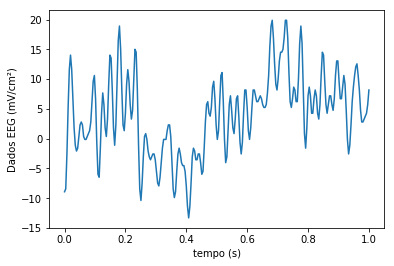

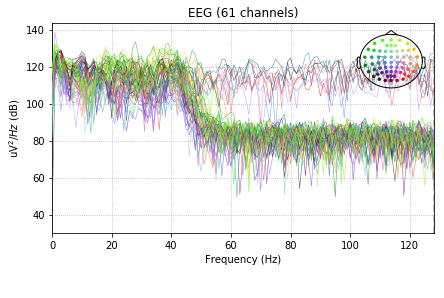

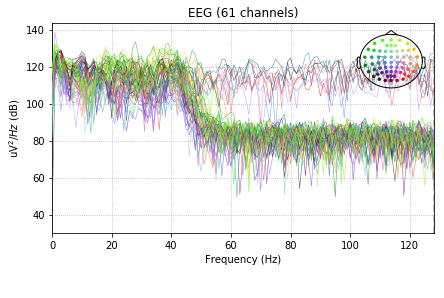

In [120]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne

# primeira sessão, primeiro trial
x = data[0][0]
print(x.shape)

ch_names = ch_names
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
raw = mne.io.RawArray(x, info)

# São removidos aqui alguns canais que não parecem ser informações de eletrodos EEG
raw.drop_channels(['x', 'nd', 'y'])

# Aplicamos a montagem do padrão 10-20 para todos os eletrodos
# 
montage = mne.channels.read_montage('standard_1020')
raw.set_montage(montage)

# Neste primeiro gráfico mostramos o sinal de um eletrodo no domínio do tempo
plt.plot(np.linspace(0, 1, 256), raw.get_data()[0])
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

# Aqui mostramos todos os 61 eletrodos que representam dados EEG
raw.plot_psd()

### Aplicação de filtros temporais

A base de dados `EEG Dataset` possui um sinal no tempo muito curto

Tentamos aplicar um filtro notch em 60 Hz e como segundo parâmetro, um múltiplo de frequência de Nyquist equivalente à taxa de amostagem de 256 Hz (128 Hz). Ou seja, o maior múltiplo de 60 Hz menor que a taxa de Nyquist é 120 Hz. Então posicionamos em range máximo de 121.

Setting up band-stop filter
Filter length of 1691 samples (6.605 sec) selected
Setting up band-pass filter from 5 - 50 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 423 samples (1.652 sec) selected
Effective window size : 1.000 (s)


<ipython-input-121-938cafc5dd54>:4: RuntimeWarning: filter_length (1691) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw2.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
<ipython-input-121-938cafc5dd54>:5: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw2.filter(5., 50., fir_design='firwin')


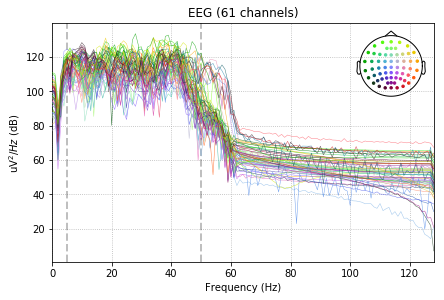

In [121]:
from copy import deepcopy

raw2 = deepcopy(raw)
raw2.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
raw2.filter(5., 50., fir_design='firwin')
raw2.plot_psd(area_mode='range')
print()

Percebemos aqui duas coisas:
- Os filtros funcionaram bem para todos os canais aplicando um notch em 60 Hz e um bandpass de 5 - 50 Hz
- São mostrados dois `warnings` importantes: a largura especificada (padrão) para o filtro é maior que o sinal definido em 256 pontos (256 Hz). Além disso, é necessário ajustar a `banda de transição` para acontecer o "corte" do filtro, ou seja, a transição que ocorre entre a banda passante e a banda não passante. A figura a seguir mostra uma corte na frequência de 2 kHz:

![](https://upload.wikimedia.org/wikipedia/commons/7/76/Butterworth_lowpass.png)

Desta forma, foram encontrados os valores de banda de transição tanto para o filtro `notch` quanto para o `bandpass`, além de reduzir a amostra de 1 segundo para 996 ms para ocorrer a banda de transição. Estes ajustes eliminam uma porção mínima de dados, porém evitam possíveis distorções no sinal após a aplicação dos filtros.

Setting up band-stop filter
Filter length of 255 samples (0.996 sec) selected
Setting up band-pass filter from 5 - 50 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 255 samples (0.996 sec) selected
Effective window size : 1.000 (s)


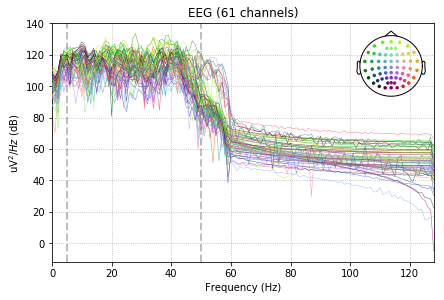

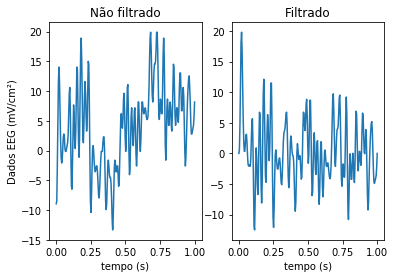

In [122]:
raw3 = deepcopy(raw)
raw3.notch_filter(np.arange(60, 121, 60), fir_design='firwin', trans_bandwidth=6.7, filter_length='996ms')
raw3.filter(5., 50., fir_design='firwin', l_trans_bandwidth=3.35, filter_length='996ms')
raw3.plot_psd(area_mode='range')

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
ax.plot(np.linspace(0, 1, 256), raw.get_data()[0])
plt.title('Não filtrado')
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.linspace(0, 1, 256), raw3.get_data()[0])
plt.title('Filtrado')
plt.xlabel('tempo (s)')
print()

A aplicação dos filtros temporais neste dataset não ajudam necessariamente melhorar de algumaforma o sinal medido, mas nos dá uma boa ideia de como funcionam a aplicação dos filtros `notch` e `bandpass`. Para aplicar um filtro `lowpass` ou `highpass`, só é necessário a modificação do valor do 1º ou do 2º parâmetro da função `filter` para `None` respectivamente.


### Aplicação de filtros espaciais

Os filtros espaciais tem por finalidade reduzir a dimensionalidade dos dados. Quando nos referimos em sinais de EEG em relação a quantidae de eletrodos disponíveis, ou então eliminar dados em comum em relação a um conjunto de eletrodos especificados.

Um dos algoritmos utilizados par reduzir a dimensionalidade dos dados é o *Principal Component Analysis* (PCA) é um método não supervisionado rápido e flexível para a redução da dimensionalidade dos dados. Podemos utilizar este método tanto para demonstrar os dados no gráfico quanto para aplicar os algoritmos de agrupamento ou de classificação mais simples com os dados gerados por ele.

Um exemplo da redução da dimnsionalidade dos eletrodos (de 61 para apenas 1) é mostrado a seguir:

(1, 256)
Creating RawArray with float64 data, n_channels=1, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.


Text(0, 0.5, 'Dados EEG (mV/cm²)')

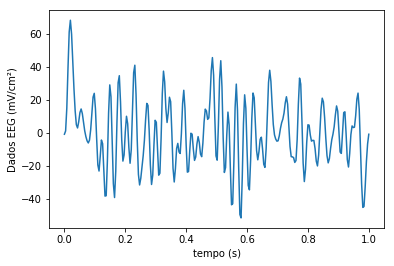

In [123]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
projected = pca.fit_transform(raw3.get_data().T).T
print(projected.shape)

info = mne.create_info(ch_names=('x',), sfreq=256)
new_raw = mne.io.RawArray(projected, info)

plt.plot(np.linspace(0, 1, 256), new_raw.get_data()[0])
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

Um outro modelo de algoritmo bastante aplicado é utilizar a referência média comum de um conjunto de dados. O algoritmo *Common Average Reference* (CAR) é utilizado para obter a referência média comum em relação a um conjunto de eletrodos especificados. Uma filtragem espacial pelo método CAR subtrai os artefatos comuns a todos os eletrodos. Comumente em BCI, para a redução de sinais não desejados mensurados pelo EEG, são posicionados eletrodos de referência em locais que tentam subtrair os potenciais comuns em todos os outros eletrodos. Um eletrodo de referência pode ser posicionado na região central do couro cabeludo `Cz`, processos mastoides e lóbulos da orelha. A técnica de filtragem espacial CAR reduz as componentes que estão em maior número nos eletrodos, subtraindo cada amostra do sinal pelo valor médio da diferença de potencial calculada para todos os eletrodos e a diferença aferida em cada eletrodo. A técnica CAR pode ser definida como:

\begin{equation}
V_i^{CAR} = V_i^{ER} - \frac{1}{N_e} \sum\limits_{j=1}^{N_e} V_j^{ER}
\end{equation}

onde $V_i^{ER}$ é o potencial do i-ésimo eletrodo e ${N_e}$ é o número de eletrodos utilizados.

É possível utilizar o CAR por meio do método `set_eeg_reference` da biblioteca MNE e aplicar para um conjunto de eletrodos especificados. Supondo que os eletrodos que estamos interessados estão na região parietal e sua vizinhança, segue o código:

['p3', 'p4', 'pz', 'p8', 'p7', 'po2', 'po1', 'p5', 'p6', 'po7', 'po8', 'poz', 'p2', 'p1']
Applying a custom EEG reference.
(256,)
<RawArray  |  None, n_channels x n_times : 61 x 256 (1.0 sec), ~277 kB, data loaded>


Text(0, 0.5, 'Dados EEG (mV/cm²)')

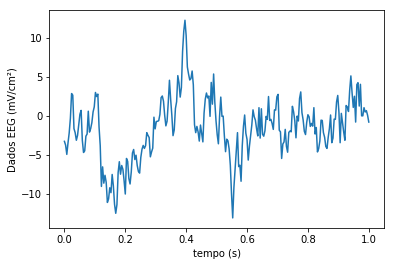

In [124]:
from mne import set_eeg_reference as car

chs_P = [c for c in raw.ch_names if c[0] == 'p']
print(chs_P)

inst, data = car(raw, ref_channels=chs_P)
print(data.shape)
print(inst)
plt.plot(np.linspace(0, 1, 256), data)
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')